In [ ]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras import datasets, layers, models
from keras import regularizers
from keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Train image shape: (32, 32, 3), Train label shap: (10,)
Validation image shape: (32, 32, 3), Validation label Shape: (10,)
Test image shape: (10000, 32, 32, 3), Test label shape: (10000, 10)


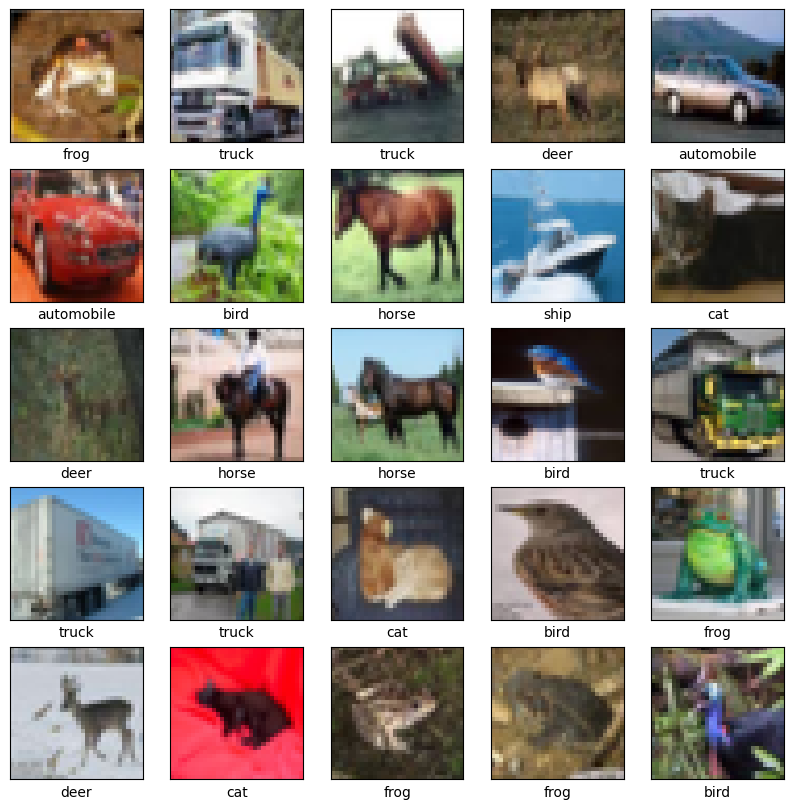

In [ ]:
import tensorflow as tf

# Load data
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

## EDA Datatype,Standarize,class label, split data
test_images = test_images.astype('float32')
train_images = train_images.astype('float32')


test_images = test_images / 255
train_images = train_images / 255


num_classes = 10
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)


train_dataset, valid_dataset = keras.utils.split_dataset((train_images, train_labels), left_size=0.8, shuffle=True)

# Data Info
train_images_shape = tf.data.experimental.get_structure(train_dataset)[0].shape
train_labels_shape = tf.data.experimental.get_structure(train_dataset)[1].shape
val_images_shape = tf.data.experimental.get_structure(valid_dataset)[0].shape
val_labels_shape = tf.data.experimental.get_structure(valid_dataset)[1].shape

print(f"Train image shape: {train_images_shape}, Train label shap: {train_labels_shape}")
print(f"Validation image shape: {val_images_shape}, Validation label Shape: {val_labels_shape}")
print(f"Test image shape: {test_images.shape}, Test label shape: {test_labels.shape}")

# Create class name
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Visual Training Sample
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(train_images, train_labels)):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[np.argmax(label)])
    if i == 24:
        break

plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define Cifar10CnnModel
class Cifar10CnnModel(nn.Module):
    def __init__(self):
        super(Cifar10CnnModel, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),


            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, xb):
        return self.network(xb)

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch+1}], val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

cnn_model = Cifar10CnnModel()
print(cnn_model)

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = datasets.CIFAR10(root='data/', train=True, download=True, transform=transform)
val_size = 5000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

initial_result = evaluate(cnn_model, val_loader=val_loader)
print(f"Initial Results - val_loss: {initial_result['val_loss']:.4f}, val_acc: {initial_result['val_acc']:.4f}")




Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


Extracting data/cifar-10-python.tar.gz to data/
Initial Results - val_loss: 2.3025, val_acc: 0.1003


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.optim.lr_scheduler as lr_scheduler


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = datasets.CIFAR10(root='data/', train=True, download=True, transform=transform)
val_size = 5000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

cnn_model = Cifar10CnnModel()


optimizer = optim.Adam(cnn_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
max_lr = 0.01
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=7, verbose=True, threshold=1e-4, cooldown=0, min_lr=1e-5)
early_stopping_patience = 10


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, model, train_loader, val_loader, optimizer, criterion, scheduler, early_stopping_patience):
    history = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_losses = []
        train_accs = []
        for batch in train_loader:
            images, labels = batch
            outputs = model(images)
            loss = criterion(outputs, labels)
            train_losses.append(loss)
            acc = accuracy(outputs, labels)
            train_accs.append(acc)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()
        result['learning_rate'] = optimizer.param_groups[0]['lr']
        model.epoch_end(epoch, result)
        history.append(result)
        scheduler.step(result['val_loss'])
        for param_group in optimizer.param_groups:
            if param_group['lr'] > max_lr:
                param_group['lr'] = max_lr

        if result['val_loss'] < best_val_loss:
            best_val_loss = result['val_loss']
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered.")
                break

    return history


def epoch_end(self, epoch, result):
    print(f"Epoch [{epoch+1}], train_loss: {result['train_loss']:.4f}, train_acc: {result['train_acc']:.4f}, "
          f"val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}, learning_rate: {result['learning_rate']:.6f}")


Cifar10CnnModel.epoch_end = epoch_end


num_epochs = 10
history = fit(num_epochs, cnn_model, train_loader, val_loader, optimizer, criterion, scheduler, early_stopping_patience)


Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1], train_loss: 1.5848, train_acc: 0.4035, val_loss: 1.2097, val_acc: 0.5589, learning_rate: 0.001000
Epoch [2], train_loss: 1.0332, train_acc: 0.6308, val_loss: 0.9594, val_acc: 0.6580, learning_rate: 0.001000
Epoch [3], train_loss: 0.7707, train_acc: 0.7288, val_loss: 0.7867, val_acc: 0.7308, learning_rate: 0.001000
Epoch [4], train_loss: 0.6103, train_acc: 0.7857, val_loss: 0.7090, val_acc: 0.7631, learning_rate: 0.001000
Epoch [5], train_loss: 0.4745, train_acc: 0.8347, val_loss: 0.7325, val_acc: 0.7593, learning_rate: 0.001000
Epoch [6], train_loss: 0.3715, train_acc: 0.8689, val_loss: 0.7198, val_acc: 0.7727, learning_rate: 0.001000
Epoch [7], train_loss: 0.2839, train_acc: 0.9004, val_loss: 0.8142, val_acc: 0.7751, learning_rate: 0.001000
Epoch [8], train_loss: 0.2225, train_acc: 0.9217, val_loss: 0.8670, val_acc: 0.7830, learning_rate: 0.001000
Epoch [9], train_loss: 0.1791, train_acc: 0.9368, val_loss: 0.9956, val_acc: 0.7789, learning_rate: 0.001000
Epoch [10], train_l

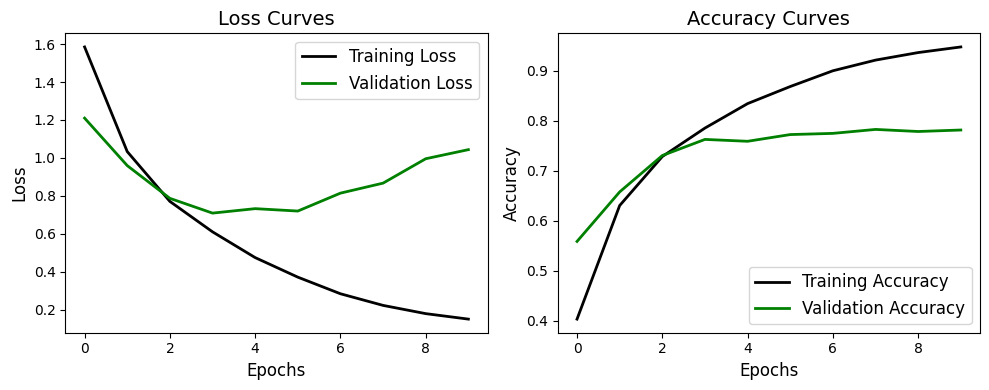

In [ ]:
import matplotlib.pyplot as plt

train_losses = [x['train_loss'] for x in history]
val_losses = [x['val_loss'] for x in history]
train_accuracies = [x['train_acc'] for x in history]
val_accuracies = [x['val_acc'] for x in history]


plt.figure(figsize=[10, 4])
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'black', linewidth=2.0)
plt.plot(val_losses, 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Curves', fontsize=14)


plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'black', linewidth=2.0)
plt.plot(val_accuracies, 'green', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy Curves', fontsize=14)

plt.tight_layout()
plt.show()

Files already downloaded and verified
Model file not found. Please make sure the model weights file 'model_cifar10.pth' is available.
Test Accuracy for 25 images = 64.00%


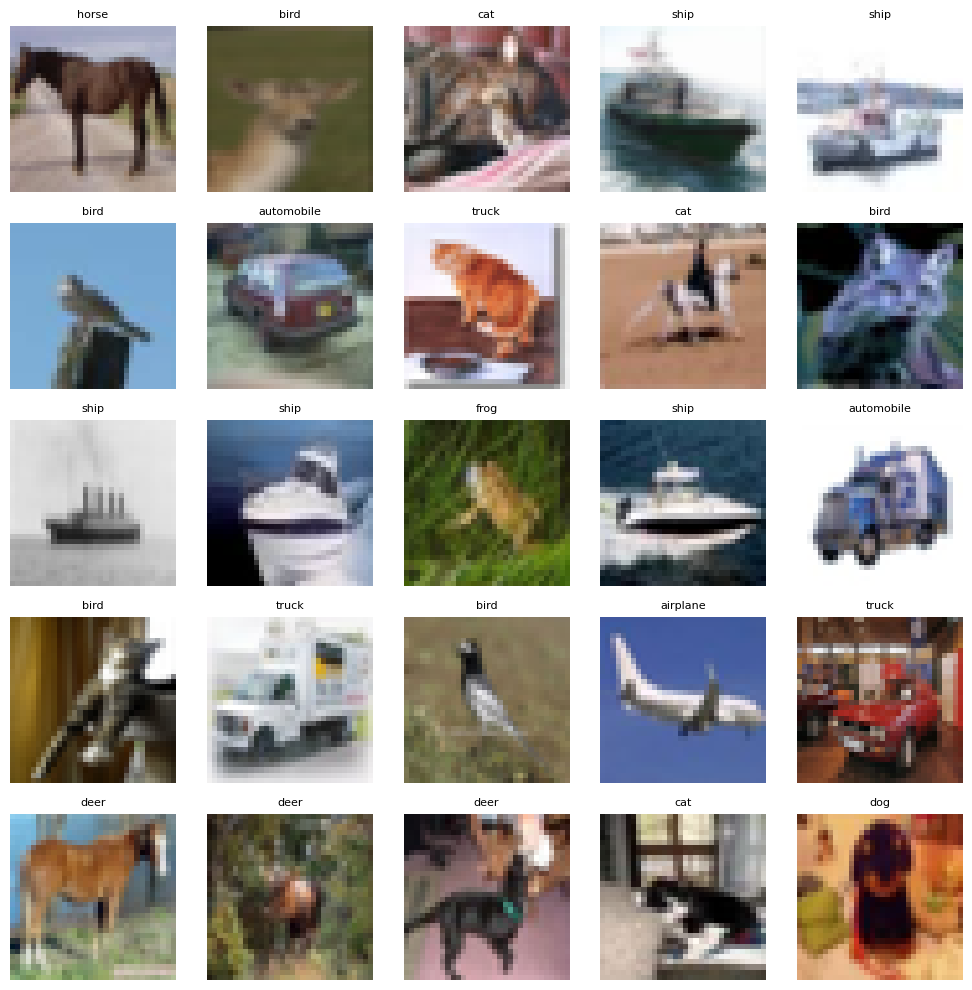

In [ ]:

import torch
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_dataset = datasets.CIFAR10(root='data/', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=25, shuffle=True)

try:
    cnn_model.load_state_dict(torch.load('./model_cifar10.pth', weights_only=True))
except FileNotFoundError:
    print("Model file not found. Please make sure the model weights file 'model_cifar10.pth' is available.")
cnn_model.eval()

images, labels = next(iter(test_loader))


outputs = cnn_model(images)
_, pred_classes = torch.max(outputs, dim=1)


pred_classes = pred_classes.numpy()
true_classes = labels.numpy()

accuracy = (pred_classes == true_classes).sum() * 1.0 / len(true_classes)
print('Test Accuracy for 25 images = {:.2f}%'.format(accuracy * 100))


class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(np.transpose(images[i].numpy(), (1, 2, 0)) * 0.5 + 0.5)  #
    plt.title(class_names[pred_classes[i]], fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


Res-Net 18

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))


class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet18(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.layer1 = self._make_layer(ResNetBlock, 64, 64, 2, stride=1)
        self.layer2 = self._make_layer(ResNetBlock, 64, 128, 2, stride=2)
        self.layer3 = self._make_layer(ResNetBlock, 128, 256, 2, stride=2)
        self.layer4 = self._make_layer(ResNetBlock, 256, 512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(block(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.layer0(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet18 = ResNet18(3, 100).to(device)


print(model_resnet18)


def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []


    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):

        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()


            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()


            lrs.append(optimizer.param_groups[0]['lr'])
            sched.step()


        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history



ResNet18(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2

In [ ]:
import torch


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step((batch[0].to(device), batch[1].to(device))) for batch in val_loader]
    return model.validation_epoch_end(outputs)


from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = datasets.CIFAR10(root='data/', train=True, download=True, transform=transform)
val_size = 5000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
initial_result = evaluate(model_resnet18, val_loader)
print(f"Initial Results - val_loss: {initial_result['val_loss']:.4f}, val_acc: {initial_result['val_acc']:.4f}")


epochs_resnet18 = 15
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-5
opt_func = torch.optim.Adam

Files already downloaded and verified
Initial Results - val_loss: 4.6071, val_acc: 0.0028


In [ ]:

from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)


def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []


    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):

        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            loss = model.training_step((images, labels))
            train_losses.append(loss)
            loss.backward()


            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()


            lrs.append(optimizer.param_groups[0]['lr'])
            sched.step()


        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history


history_resnet18 = fit_one_cycle(epochs_resnet18, max_lr, model_resnet18, train_loader, val_loader, weight_decay=weight_decay, grad_clip=grad_clip, opt_func=opt_func)


Epoch [0], last_lr: 0.00152, train_loss: 1.4473, val_loss: 1.2950, val_acc: 0.5419
Epoch [1], last_lr: 0.00436, train_loss: 1.1810, val_loss: 1.3136, val_acc: 0.5809
Epoch [2], last_lr: 0.00760, train_loss: 1.0462, val_loss: 1.4395, val_acc: 0.5540
Epoch [3], last_lr: 0.00971, train_loss: 0.9479, val_loss: 1.0403, val_acc: 0.6404
Epoch [4], last_lr: 0.00994, train_loss: 0.8081, val_loss: 0.8651, val_acc: 0.7047
Epoch [5], last_lr: 0.00950, train_loss: 0.7228, val_loss: 0.9528, val_acc: 0.6845
Epoch [6], last_lr: 0.00867, train_loss: 0.6429, val_loss: 0.8425, val_acc: 0.7239
Epoch [7], last_lr: 0.00750, train_loss: 0.5673, val_loss: 0.7477, val_acc: 0.7464
Epoch [8], last_lr: 0.00611, train_loss: 0.4854, val_loss: 0.7726, val_acc: 0.7530
Epoch [9], last_lr: 0.00463, train_loss: 0.3766, val_loss: 0.7196, val_acc: 0.7714
Epoch [10], last_lr: 0.00317, train_loss: 0.2492, val_loss: 0.7508, val_acc: 0.7826
Epoch [11], last_lr: 0.00188, train_loss: 0.1343, val_loss: 0.8794, val_acc: 0.7905
Ep

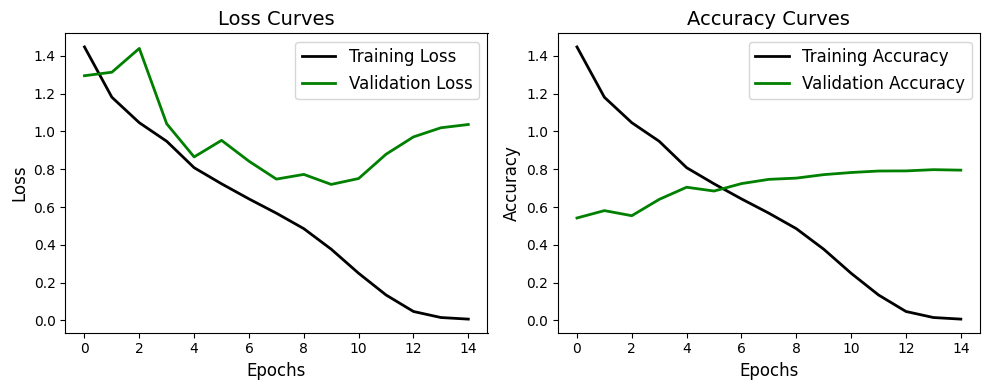

In [ ]:
import matplotlib.pyplot as plt


train_losses = [x['train_loss'] for x in history_resnet18]
val_losses = [x['val_loss'] for x in history_resnet18]
train_accuracies = [x['train_loss'] for x in history_resnet18]
val_accuracies = [x['val_acc'] for x in history_resnet18]

plt.figure(figsize=[10, 4])
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'black', linewidth=2.0)
plt.plot(val_losses, 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Curves', fontsize=14)


plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'black', linewidth=2.0)
plt.plot(val_accuracies, 'green', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy Curves', fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:

test_dataset = datasets.CIFAR10(root='data/', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

test_result = evaluate(model_resnet18, test_loader)
print(f"Test Results - val_loss: {test_result['val_loss']:.4f}, val_acc: {test_result['val_acc']:.4f}")


Files already downloaded and verified
Test Results - val_loss: 1.0844, val_acc: 0.7884


Accuracy for 25 images: 84.00%


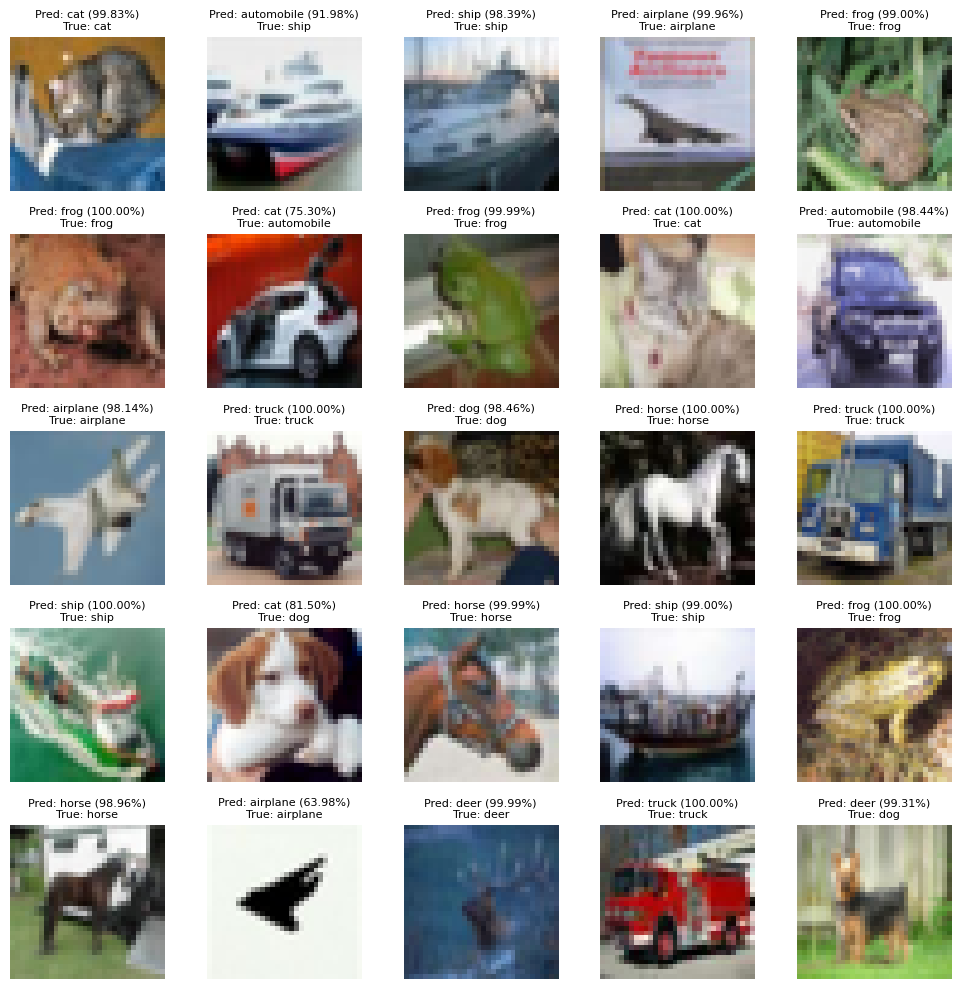

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


images, labels = next(iter(test_loader))
images, labels = images[:25], labels[:25]
images = images.to(device)


model_resnet18.eval()
outputs = model_resnet18(images)
_, pred_classes = torch.max(outputs, dim=1)
probabilities = torch.softmax(outputs, dim=1)


pred_classes = pred_classes.cpu().numpy()
true_classes = labels.cpu().numpy()
probabilities = probabilities.detach().cpu().numpy()


accuracy = (pred_classes == true_classes).sum() / len(true_classes)
print(f"Accuracy for 25 images: {accuracy * 100:.2f}%")

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)) * 0.5 + 0.5)
    pred_label = class_names[pred_classes[i]]
    true_label = class_names[true_classes[i]]
    confidence = probabilities[i, pred_classes[i]] * 100
    plt.title(f"Pred: {pred_label} ({confidence:.2f}%)\nTrue: {true_label}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


**VGG**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = (out.argmax(dim=1) == labels).float().mean()
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [torch.tensor(x['val_acc']) for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

class VGGModel(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.features = self._make_layers()
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _make_layers(self):
        layers = []
        in_channels = 3
        cfg = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, v, kernel_size=3, padding=1),
                           nn.BatchNorm2d(v),
                           nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg = VGGModel(10).to(device)

print(model_vgg)

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = datasets.CIFAR10(root='data/', train=True, download=True, transform=transform)
val_size = 5000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step((batch[0].to(device), batch[1].to(device))) for batch in val_loader]
    outputs = [{'val_loss': x['val_loss'].detach(), 'val_acc': torch.tensor(x['val_acc'])} for x in outputs]
    return model.validation_epoch_end(outputs)

initial_result = evaluate(model_vgg, val_loader)
print(f"Initial Results - val_loss: {initial_result['val_loss']:.4f}, val_acc: {initial_result['val_acc']:.4f}")


VGGModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool

<ipython-input-16-e265d4583f9a>:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = [{'val_loss': x['val_loss'].detach(), 'val_acc': torch.tensor(x['val_acc'])} for x in outputs]
<ipython-input-16-e265d4583f9a>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_accs = [torch.tensor(x['val_acc']) for x in outputs]


In [ ]:

epochs_vgg = 15
max_lr_vgg = 0.01
grad_clip_vgg = 0.1
weight_decay_vgg = 1e-5
opt_func_vgg = torch.optim.SGD

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []


    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    sched = OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):

        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            loss = model.training_step((images, labels))
            train_losses.append(loss)
            loss.backward()


            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()


            lrs.append(optimizer.param_groups[0]['lr'])
            sched.step()


        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history

history_vgg = fit_one_cycle(epochs_vgg, max_lr_vgg, model_vgg, train_loader, val_loader, weight_decay=weight_decay_vgg, grad_clip=grad_clip_vgg, opt_func=opt_func_vgg)


<ipython-input-16-e265d4583f9a>:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = [{'val_loss': x['val_loss'].detach(), 'val_acc': torch.tensor(x['val_acc'])} for x in outputs]
<ipython-input-16-e265d4583f9a>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_accs = [torch.tensor(x['val_acc']) for x in outputs]


Epoch [0], last_lr: 0.00152, train_loss: 1.4760, val_loss: 1.2447, val_acc: 0.5795
Epoch [1], last_lr: 0.00436, train_loss: 0.9663, val_loss: 1.0482, val_acc: 0.6448
Epoch [2], last_lr: 0.00760, train_loss: 0.7701, val_loss: 0.8268, val_acc: 0.7176
Epoch [3], last_lr: 0.00971, train_loss: 0.6234, val_loss: 0.8800, val_acc: 0.7160
Epoch [4], last_lr: 0.00994, train_loss: 0.4930, val_loss: 0.6726, val_acc: 0.7771
Epoch [5], last_lr: 0.00950, train_loss: 0.3829, val_loss: 0.7840, val_acc: 0.7652
Epoch [6], last_lr: 0.00867, train_loss: 0.3020, val_loss: 0.5821, val_acc: 0.8109
Epoch [7], last_lr: 0.00750, train_loss: 0.2189, val_loss: 0.6849, val_acc: 0.8048
Epoch [8], last_lr: 0.00611, train_loss: 0.1554, val_loss: 0.7037, val_acc: 0.8060
Epoch [9], last_lr: 0.00463, train_loss: 0.1070, val_loss: 0.6803, val_acc: 0.8252
Epoch [10], last_lr: 0.00317, train_loss: 0.0587, val_loss: 0.7958, val_acc: 0.8236
Epoch [11], last_lr: 0.00188, train_loss: 0.0240, val_loss: 0.7795, val_acc: 0.8366
Ep

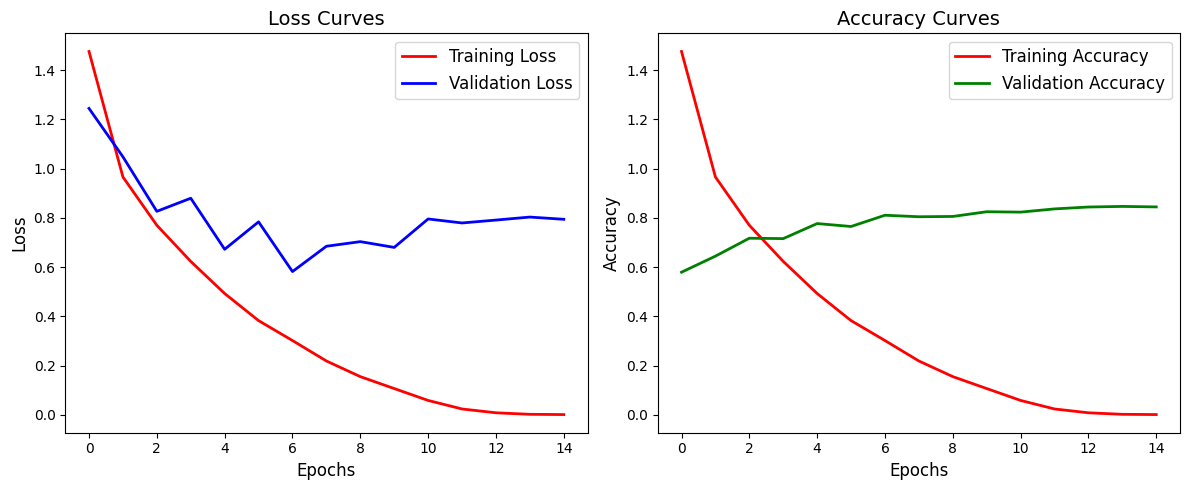

In [ ]:
import matplotlib.pyplot as plt


train_losses = [x['train_loss'] for x in history_vgg]
val_losses = [x['val_loss'] for x in history_vgg]
train_accuracies = [x['train_loss'] for x in history_vgg]
val_accuracies = [x['val_acc'] for x in history_vgg]


plt.figure(figsize=[12, 5])
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'r', linewidth=2.0)
plt.plot(val_losses, 'b', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Curves', fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'r', linewidth=2.0)
plt.plot(val_accuracies, 'g', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy Curves', fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:

test_dataset = datasets.CIFAR10(root='data/', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


test_result = evaluate(model_vgg, test_loader)
print(f"Test Results - val_loss: {test_result['val_loss']:.4f}, val_acc: {test_result['val_acc']:.4f}")


Files already downloaded and verified
Test Results - val_loss: 0.8423, val_acc: 0.8460


<ipython-input-16-e265d4583f9a>:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = [{'val_loss': x['val_loss'].detach(), 'val_acc': torch.tensor(x['val_acc'])} for x in outputs]
<ipython-input-16-e265d4583f9a>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_accs = [torch.tensor(x['val_acc']) for x in outputs]


Accuracy for 25 images: 84.00%


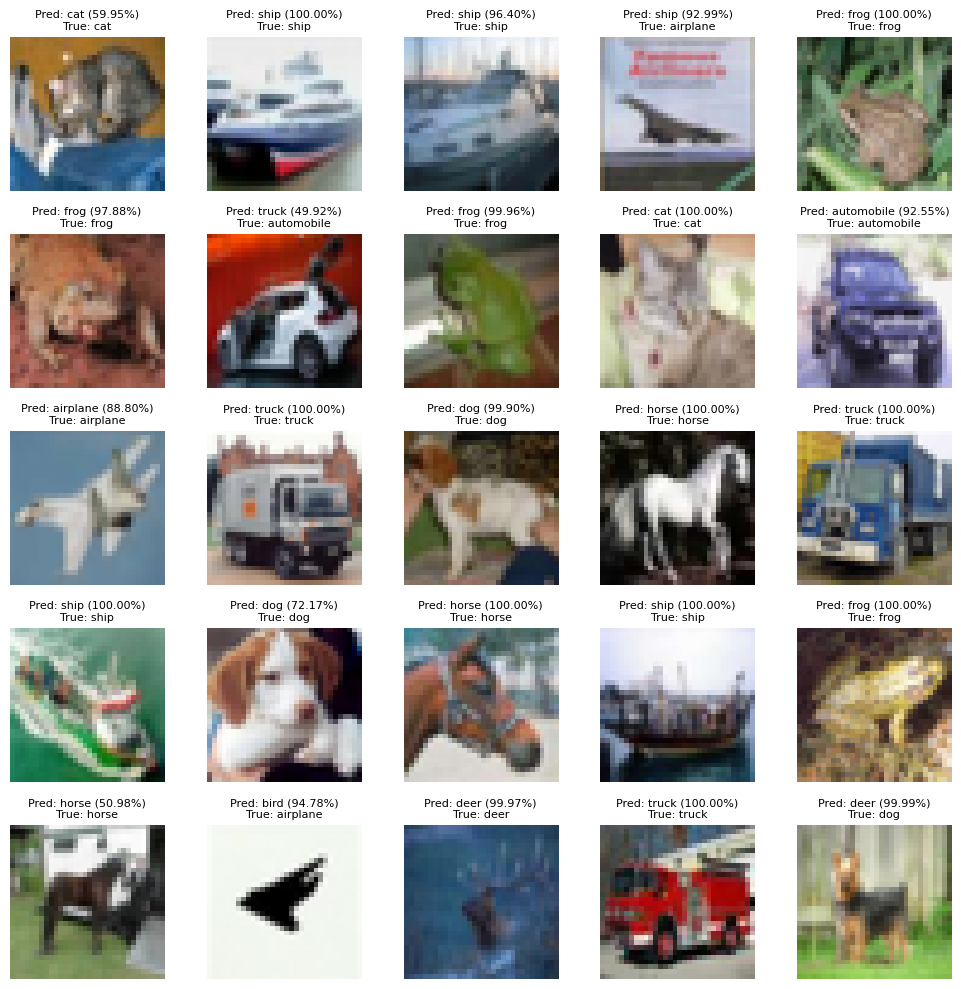

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


images, labels = next(iter(test_loader))
images, labels = images[:25], labels[:25]
images = images.to(device)


model_vgg.eval()
outputs = model_vgg(images)
_, pred_classes = torch.max(outputs, dim=1)
probabilities = torch.softmax(outputs, dim=1)


pred_classes = pred_classes.cpu().numpy()
true_classes = labels.cpu().numpy()
probabilities = probabilities.detach().cpu().numpy()


accuracy = (pred_classes == true_classes).sum() / len(true_classes)
print(f"Accuracy for 25 images: {accuracy * 100:.2f}%")

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)) * 0.5 + 0.5)
    pred_label = class_names[pred_classes[i]]
    true_label = class_names[true_classes[i]]
    confidence = probabilities[i, pred_classes[i]] * 100
    plt.title(f"Pred: {pred_label} ({confidence:.2f}%)\nTrue: {true_label}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()



LeNet Model


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = (out.argmax(dim=1) == labels).float().mean()
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [torch.tensor(x['val_acc']) for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

class LeNet(ImageClassificationBase):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_lenet = LeNet(10).to(device)


print(model_lenet)


from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = datasets.CIFAR10(root='data/', train=True, download=True, transform=transform)
val_size = 5000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step((batch[0].to(device), batch[1].to(device))) for batch in val_loader]
    outputs = [{'val_loss': x['val_loss'].detach(), 'val_acc': torch.tensor(x['val_acc'])} for x in outputs]
    return model.validation_epoch_end(outputs)

initial_result = evaluate(model_lenet, val_loader)
print(f"Initial Results - val_loss: {initial_result['val_loss']:.4f}, val_acc: {initial_result['val_acc']:.4f}")


epochs_lenet = 15
max_lr_lenet = 0.01
grad_clip_lenet = 0.1
weight_decay_lenet = 1e-5
opt_func_lenet = torch.optim.SGD


LeNet(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)
Files already downloaded and verified
Initial Results - val_loss: 2.3037, val_acc: 0.1028


<ipython-input-43-2f6f9ceaec52>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = [{'val_loss': x['val_loss'].detach(), 'val_acc': torch.tensor(x['val_acc'])} for x in outputs]
<ipython-input-43-2f6f9ceaec52>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_accs = [torch.tensor(x['val_acc']) for x in outputs]


In [ ]:
from torch.optim.lr_scheduler import OneCycleLR


train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)


def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []


    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    sched = OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):

        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            loss = model.training_step((images, labels))
            train_losses.append(loss)
            loss.backward()


            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            lrs.append(optimizer.param_groups[0]['lr'])
            sched.step()


        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history


history_lenet = fit_one_cycle(epochs_lenet, max_lr_lenet, model_lenet, train_loader, val_loader, weight_decay=weight_decay_lenet, grad_clip=grad_clip_lenet, opt_func=opt_func_lenet)


<ipython-input-43-2f6f9ceaec52>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = [{'val_loss': x['val_loss'].detach(), 'val_acc': torch.tensor(x['val_acc'])} for x in outputs]
<ipython-input-43-2f6f9ceaec52>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_accs = [torch.tensor(x['val_acc']) for x in outputs]


Epoch [0], last_lr: 0.00152, train_loss: 2.2997, val_loss: 2.2797, val_acc: 0.1780
Epoch [1], last_lr: 0.00436, train_loss: 1.9384, val_loss: 1.7229, val_acc: 0.3570
Epoch [2], last_lr: 0.00760, train_loss: 1.5615, val_loss: 1.4546, val_acc: 0.4713
Epoch [3], last_lr: 0.00971, train_loss: 1.3755, val_loss: 1.3616, val_acc: 0.5125
Epoch [4], last_lr: 0.00994, train_loss: 1.2564, val_loss: 1.2445, val_acc: 0.5580
Epoch [5], last_lr: 0.00950, train_loss: 1.1693, val_loss: 1.2170, val_acc: 0.5684
Epoch [6], last_lr: 0.00867, train_loss: 1.0925, val_loss: 1.1706, val_acc: 0.5902
Epoch [7], last_lr: 0.00750, train_loss: 1.0357, val_loss: 1.1933, val_acc: 0.5938
Epoch [8], last_lr: 0.00611, train_loss: 0.9759, val_loss: 1.1710, val_acc: 0.5938
Epoch [9], last_lr: 0.00463, train_loss: 0.9176, val_loss: 1.1050, val_acc: 0.6228
Epoch [10], last_lr: 0.00317, train_loss: 0.8587, val_loss: 1.0941, val_acc: 0.6216
Epoch [11], last_lr: 0.00188, train_loss: 0.7959, val_loss: 1.0930, val_acc: 0.6333
Ep

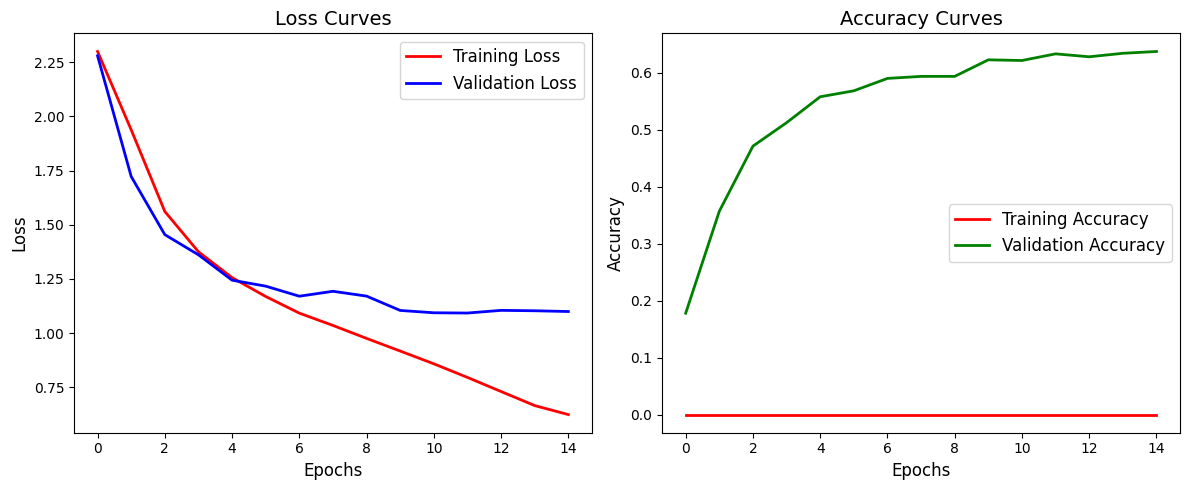

In [ ]:
import matplotlib.pyplot as plt


train_losses = [x['train_loss'] for x in history_lenet]
val_losses = [x['val_loss'] for x in history_lenet]
train_accuracies = [x.get('train_acc', 0) for x in history_lenet]
val_accuracies = [x['val_acc'] for x in history_lenet]


plt.figure(figsize=[12, 5])
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'r', linewidth=2.0)
plt.plot(val_losses, 'b', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Curves', fontsize=14)


plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'r', linewidth=2.0)
plt.plot(val_accuracies, 'g', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy Curves', fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:

test_dataset = datasets.CIFAR10(root='data/', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


test_result = evaluate(model_lenet, test_loader)
print(f"Test Results - val_loss: {test_result['val_loss']:.4f}, val_acc: {test_result['val_acc']:.4f}")


Files already downloaded and verified
Test Results - val_loss: 1.0616, val_acc: 0.6534


<ipython-input-43-2f6f9ceaec52>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = [{'val_loss': x['val_loss'].detach(), 'val_acc': torch.tensor(x['val_acc'])} for x in outputs]
<ipython-input-43-2f6f9ceaec52>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_accs = [torch.tensor(x['val_acc']) for x in outputs]


Accuracy for 25 images: 68.00%


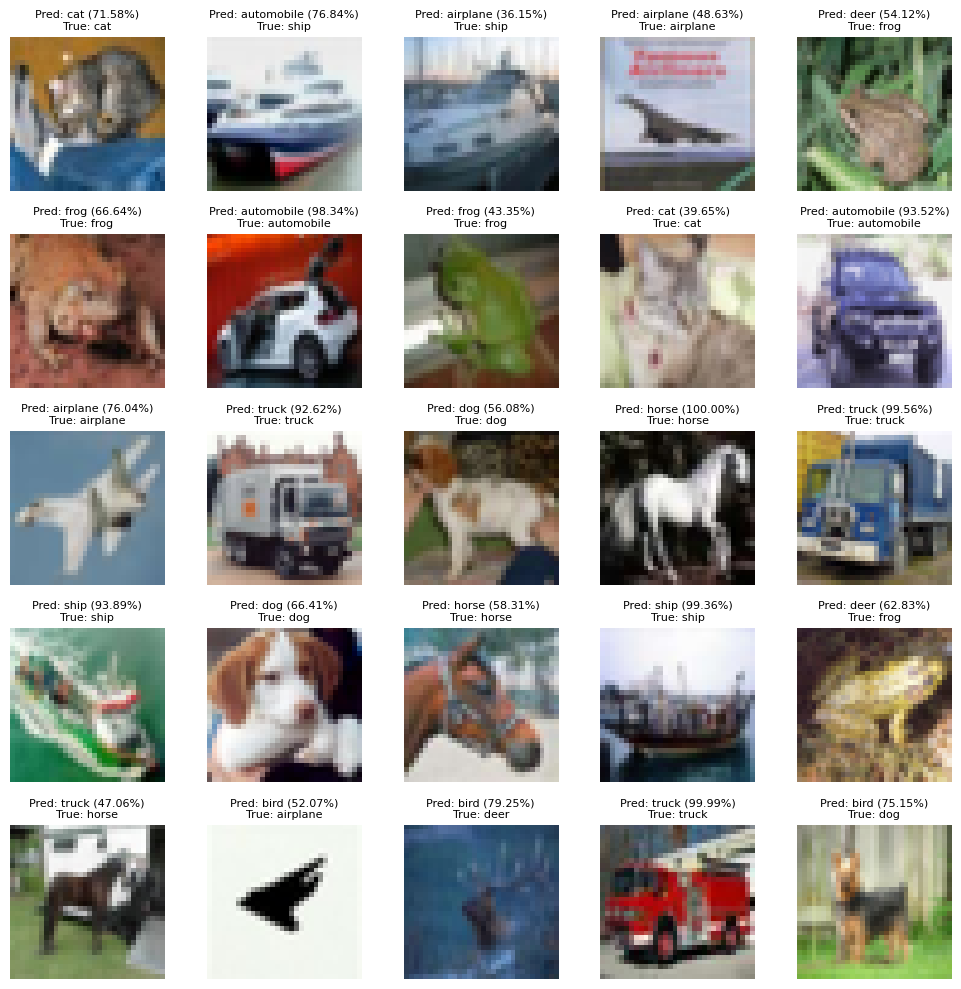

In [ ]:

import numpy as np
import matplotlib.pyplot as plt


images, labels = next(iter(test_loader))
images, labels = images[:25], labels[:25]
images = images.to(device)


model_lenet.eval()
outputs = model_lenet(images)
_, pred_classes = torch.max(outputs, dim=1)
probabilities = torch.softmax(outputs, dim=1)


pred_classes = pred_classes.cpu().numpy()
true_classes = labels.cpu().numpy()
probabilities = probabilities.detach().cpu().numpy()


accuracy = (pred_classes == true_classes).sum() / len(true_classes)
print(f"Accuracy for 25 images: {accuracy * 100:.2f}%")


class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)) * 0.5 + 0.5)
    pred_label = class_names[pred_classes[i]]
    true_label = class_names[true_classes[i]]
    confidence = probabilities[i, pred_classes[i]] * 100
    plt.title(f"Pred: {pred_label} ({confidence:.2f}%)\nTrue: {true_label}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


MobileNet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = (out.argmax(dim=1) == labels).float().mean()
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [torch.tensor(x['val_acc']) for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

class MobileNetV2Model(ImageClassificationBase):
    def __init__(self, num_classes):
        super(MobileNetV2Model, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)

        self.mobilenet.classifier[1] = nn.Linear(self.mobilenet.last_channel, num_classes)

    def forward(self, x):
        return self.mobilenet(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mobilenet = MobileNetV2Model(10).to(device)


print(model_mobilenet)


from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = datasets.CIFAR10(root='data/', train=True, download=True, transform=transform)
val_size = 5000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step((batch[0].to(device), batch[1].to(device))) for batch in val_loader]
    outputs = [{'val_loss': x['val_loss'].detach(), 'val_acc': torch.tensor(x['val_acc'])} for x in outputs]
    return model.validation_epoch_end(outputs)

initial_result = evaluate(model_mobilenet, val_loader)
print(f"Initial Results - val_loss: {initial_result['val_loss']:.4f}, val_acc: {initial_result['val_acc']:.4f}")

epochs_mobilenet = 15
max_lr_mobilenet = 0.01
grad_clip_mobilenet = 0.1
weight_decay_mobilenet = 1e-5
opt_func_mobilenet = torch.optim.Adam

MobileNetV2Model(
  (mobilenet): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_

<ipython-input-23-604d81c6b303>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = [{'val_loss': x['val_loss'].detach(), 'val_acc': torch.tensor(x['val_acc'])} for x in outputs]
<ipython-input-23-604d81c6b303>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_accs = [torch.tensor(x['val_acc']) for x in outputs]


In [ ]:
from torch.optim.lr_scheduler import OneCycleLR


train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)


def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []


    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    sched = OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):

        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            loss = model.training_step((images, labels))
            train_losses.append(loss)
            loss.backward()


            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()


            lrs.append(optimizer.param_groups[0]['lr'])
            sched.step()


        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history


history_mobilenet = fit_one_cycle(epochs_mobilenet, max_lr_mobilenet, model_mobilenet, train_loader, val_loader, weight_decay=weight_decay_mobilenet, grad_clip=grad_clip_mobilenet, opt_func=opt_func_mobilenet)


<ipython-input-23-604d81c6b303>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = [{'val_loss': x['val_loss'].detach(), 'val_acc': torch.tensor(x['val_acc'])} for x in outputs]
<ipython-input-23-604d81c6b303>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_accs = [torch.tensor(x['val_acc']) for x in outputs]


Epoch [0], last_lr: 0.00152, train_loss: 1.0439, val_loss: 0.9304, val_acc: 0.6881
Epoch [1], last_lr: 0.00436, train_loss: 1.3408, val_loss: 2.3481, val_acc: 0.1523
Epoch [2], last_lr: 0.00760, train_loss: 2.2711, val_loss: 1.9743, val_acc: 0.2237
Epoch [3], last_lr: 0.00971, train_loss: 1.8207, val_loss: 1.6301, val_acc: 0.3730
Epoch [4], last_lr: 0.00994, train_loss: 1.5114, val_loss: 1.5022, val_acc: 0.4128
Epoch [5], last_lr: 0.00950, train_loss: 1.3464, val_loss: 1.3546, val_acc: 0.5047
Epoch [6], last_lr: 0.00867, train_loss: 1.2326, val_loss: 1.2847, val_acc: 0.5431
Epoch [7], last_lr: 0.00750, train_loss: 1.1574, val_loss: 1.0961, val_acc: 0.6181
Epoch [8], last_lr: 0.00611, train_loss: 1.0598, val_loss: 1.0308, val_acc: 0.6420
Epoch [9], last_lr: 0.00463, train_loss: 0.9756, val_loss: 0.9515, val_acc: 0.6693
Epoch [10], last_lr: 0.00317, train_loss: 0.8918, val_loss: 0.9000, val_acc: 0.6883
Epoch [11], last_lr: 0.00188, train_loss: 0.8155, val_loss: 0.8168, val_acc: 0.7120
Ep

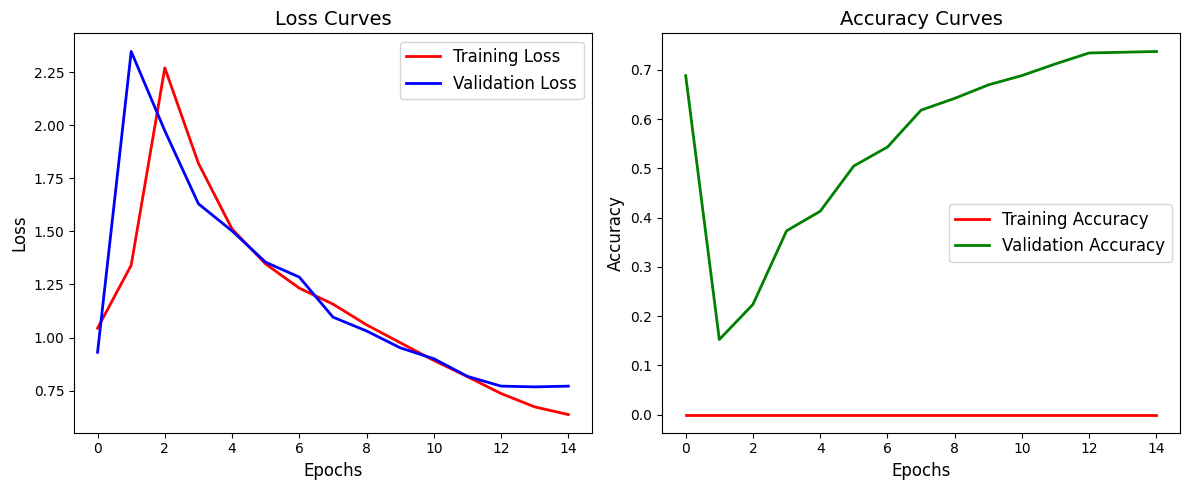

In [ ]:
import matplotlib.pyplot as plt


train_losses = [x['train_loss'] for x in history_mobilenet]
val_losses = [x['val_loss'] for x in history_mobilenet]
train_accuracies = [x.get('train_acc', 0) for x in history_mobilenet]
val_accuracies = [x['val_acc'] for x in history_mobilenet]


plt.figure(figsize=[12, 5])
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'r', linewidth=2.0)
plt.plot(val_losses, 'b', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Curves', fontsize=14)


plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'r', linewidth=2.0)
plt.plot(val_accuracies, 'g', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy Curves', fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

test_dataset = datasets.CIFAR10(root='data/', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


test_result = evaluate(model_mobilenet, test_loader)
print(f"Test Results - val_loss: {test_result['val_loss']:.4f}, val_acc: {test_result['val_acc']:.4f}")

Files already downloaded and verified
Test Results - val_loss: 0.8007, val_acc: 0.7232


<ipython-input-23-604d81c6b303>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = [{'val_loss': x['val_loss'].detach(), 'val_acc': torch.tensor(x['val_acc'])} for x in outputs]
<ipython-input-23-604d81c6b303>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_accs = [torch.tensor(x['val_acc']) for x in outputs]


Accuracy for 25 images: 84.00%


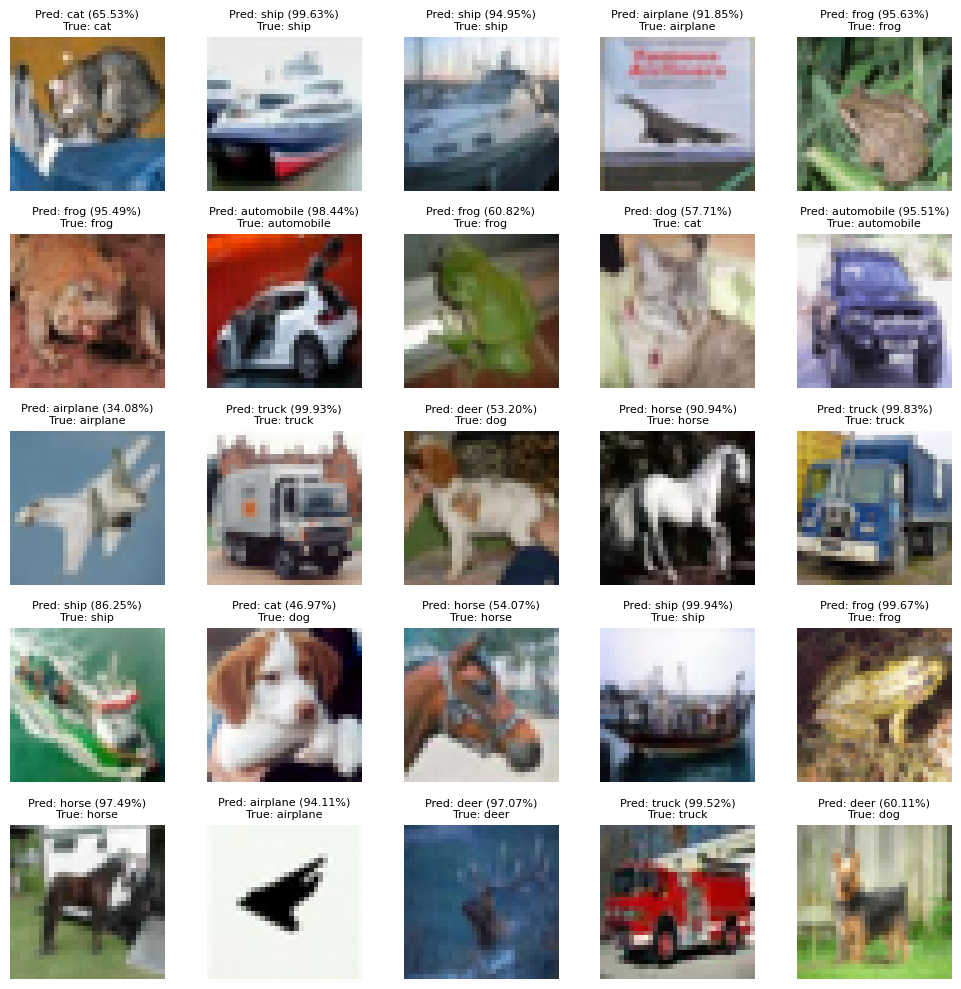

In [ ]:

images, labels = next(iter(test_loader))
images, labels = images[:25], labels[:25]
images = images.to(device)


model_mobilenet.eval()
outputs = model_mobilenet(images)
_, pred_classes = torch.max(outputs, dim=1)
probabilities = torch.softmax(outputs, dim=1)


pred_classes = pred_classes.cpu().numpy()
true_classes = labels.cpu().numpy()
probabilities = probabilities.detach().cpu().numpy()


accuracy = (pred_classes == true_classes).sum() / len(true_classes)
print(f"Accuracy for 25 images: {accuracy * 100:.2f}%")

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)) * 0.5 + 0.5)
    pred_label = class_names[pred_classes[i]]
    true_label = class_names[true_classes[i]]
    confidence = probabilities[i, pred_classes[i]] * 100
    plt.title(f"Pred: {pred_label} ({confidence:.2f}%)\nTrue: {true_label}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

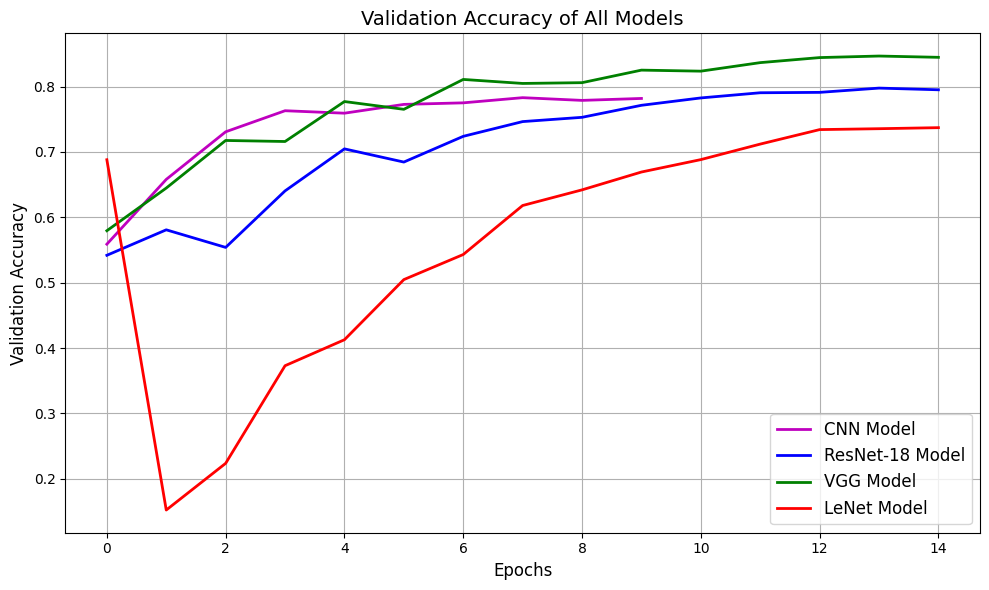

In [ ]:
import matplotlib.pyplot as plt

cnn_accuracies = [x['val_acc'] for x in history]
resnet18_accuracies = [x['val_acc'] for x in history_resnet18]
vgg_accuracies = [x['val_acc'] for x in history_vgg]
lenet_accuracies = [x['val_acc'] for x in history_Mobilenet]


plt.figure(figsize=[10, 6])
plt.plot(cnn_accuracies, 'm', linewidth=2.0, label='CNN Model')
plt.plot(resnet18_accuracies, 'b', linewidth=2.0, label='ResNet-18 Model')
plt.plot(vgg_accuracies, 'g', linewidth=2.0, label='VGG Model')
plt.plot(lenet_accuracies, 'r', linewidth=2.0, label='Mobile Model')

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('Validation Accuracy of All Models', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()